Данное исследование проводится для  интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы.

**Цель нашего исследования  -  выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании**

### Откроем файл с данными и изучим общую информацию

In [64]:
#импортируем необходимые в рамках исследования библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats as st

In [65]:
#создадим датафрейм с данными и посмотрим первые 5 строк
try:
  data = pd.read_csv('/datasets/games.csv')
except:
  data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
data.head(5)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [66]:
#Посмотрим общую информацию  о датафрейме 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [67]:
#проверим наличие полных  дубликатов в датафрейме
len(data[data.duplicated()])#дубликатов нет

0

###  Подготовим данные к исследованию

In [68]:
#Для начала приведем названия столдбцов к нижнему регистру
data.columns = data.columns.str.lower()
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Изменим типы данных в некоторых столбцах,  т.к.:
- год релиза может быть только целым числом - нужно привети к типу int64;
- оценка игр от критиков  по 100-балльной шкале также может быть только целым числом - нужно привети к типу int64;
- оценка игры от игроков по 10-балльной шкале - нужно привети к типу float64

In [69]:
data['year_of_release'] = data['year_of_release'].astype('Int64')#перевод данных в формат целого числа
data['critic_score'] = data['critic_score'].astype('Int64')#перевод данных в формат целого числа
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')#перевод данных  в формат дробного числа 

Для столбцов с годом релиза и оценкой критиков мы используем метод astype('Int64'), т.к. только с таким параметром изменится тип данных и проигнорируются строки с пропусками данных, в противном случае будет ошибка.
Столбец с оценкой игроков содержит текстовое значение "tbd", что буквально переводится как "подлежит уточнению", т.к. на основе имеющихся данных мы не можем определить значения "tbd", то его можно приравнять к пропущенным значениям. Для этого используем метод to_numeric()с параметром errors = 'coerce', который числовым значениям присвоит тип данных float64, а текстовым - значение "NaN"


In [70]:
#Теперь разберемся с пропусками в данных. Для начала посмотрим на количество пропусков в каждом столбце
#Для наглядности выведем кол-во пропусков в столбце в процентах
data.isnull().sum()/ len(data)* 100

name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         54.591684
rating             40.478612
dtype: float64

В 5 столбцах пропусков нет. В столбцах 'name' и 'genre' пропуски составляют чуть больше 0,01 %, поэтому серьезно не повлияют на результаты нашего исследования, к тому же заполнить данные пропуски довольно проблематично,  оставим их  без изменений.

Столбец с датой релиза игры имеет 1,61% пропусков, данная цифра более значима, однако достоверно установить каждое пропущенное значение и заменить на него пропуск не представляется возможным, заполнять пропуски средним или медианным значением некорректно, также как и 0, т.к. это исказит исходные  данные,  поэтому целесообразно оставить данные значения без изменений


**Учитывая небольшое количество пропусков в указанных столбцах и отсутсвие взаимосвязи с другими данными, можно сделать вывод, что пропуски значений в данных столбцах носят случайный характер, либо являются ошибкой при переносе/копировании/форматировании данных**

Столбцы с оценками игр от пользователей и критиков,  а также рейтингом от организации ESRB (англ. Entertainment Software Rating Board) имеют большое количество пропусков. Так как речь идет о рынке компьютерных игр, а данные представлены с 1980 года по 2016 год, можно сделать предположение,  что отсутвие данных об оценках обусловлено как малым количеством игр,  выпускаемых в 1980-х и 1990-х годах,  так и неразвитостью сетей информации,  благодаря которым большое количество пользователей и критиков могло бы оставлять свои оценки (интернет, специальные сайты, рейтинги).
Если говорить о рйтинге от ESRB, то сама организация появилась только в 1994 году, поэтому логично, что все игры, выпущенные и проданные ранее 1994 года,  не имели и не могли иметь оценку от этой организации.

Для проверки гипотезы сгруппируем данные в датафрейме по годам выпуска методом groupby() и посчитаем ненулевые значения в каждом столбце методом count()

In [71]:
data.groupby('year_of_release').count()

,name,platform,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
year_of_release,,,,,,,,,,
1980,9,9,9,9,9,9,9,0,0,0
1981,46,46,46,46,46,46,46,0,0,0
1982,36,36,36,36,36,36,36,0,0,0
1983,17,17,17,17,17,17,17,0,0,0
1984,14,14,14,14,14,14,14,0,0,0
1985,14,14,14,14,14,14,14,1,1,1
1986,21,21,21,21,21,21,21,0,0,0
1987,16,16,16,16,16,16,16,0,0,0
1988,15,15,15,15,15,15,15,1,1,1


Согласно полученным данным,до 1993 года количество выпускаемых игр не превышало 60 в год, а до 1996 года оценки практически не выставлялись ни пользователями,  ни критиками,  ни ESRB. Этим обуславливается часть пропусков в данных, наше предположение подтвердилось. Ситуация меняется только с 2000 года.
Также важно понять, какую часть занимают данные до 2000 года в общем количестве. Для этого количество строк, содержащих данные до 2000 года поделим на их общее кол-во и выразим в процентах:  

In [72]:
len(data.loc[data['year_of_release']<= 2000])/len(data)*100

13.915644630571345

Получилось примерно 13,9%, это означает, что остальные пропуски не обусловлены факторами, связанными с годом выпуска игры.

Вторая гипотеза - пользователи и критики меньше ставят оценки играм, которые коммерчески неуспешны, то есть имеют очень маленький показатель продаж, такие игры появляются и исчезают незамеченными.
Для проверки этой гипотезы сначала посчитаем сумму продаж копий каждой игры во всех регионах и запишем ее в стобец  total_sales:

In [73]:
data['total_sales'] = data[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

Далее посчитаем количество игр, которые были проданы тиражом менее 100 000 экземпляров во всех регионах

In [74]:
display(len(data.loc[data['total_sales']< 0.1]))# таких игр 6092 шт
len(data.loc[data['total_sales']< 0.1])/len(data)*100# и они составляют более 1/3 (36,4%) от всех игр - это немало

6092

36.44630571343105

С помощью  логической индексации мы также можем найти количество заполненных строк с оценками и рейтингом среди 6092 коммерчески неуспешных игр, чтобы найти количество незаполненных строк - вычтем из 100% полученный результат:

In [75]:
#количество пропущенных строк в столбце с оценками пользователей
display(100 - (data.loc[data['total_sales']< 0.1]['user_score'].count()/6092*100))
#количество пропущенных строк в столбце с оценками критиков
display(100 - (data.loc[data['total_sales']< 0.1]['critic_score'].count()/6092*100))
#количество пропущенных строк в столбце с рейтингом
100 - (data.loc[data['total_sales']< 0.1]['rating'].count()/6092*100)

70.3381483913329

64.49441891004597

51.641497045305314

Мы видим значительно большее количество пропущенных значений с оценками от пользовователей, критиков и рейтингом (70,3%, 64,5% и 51,6%), чем в среднем по датафрейму (54,6%, 51,3% и 40,3%), поэтому наша гипотеза о том,  что коммерчески неуспешные игры получают меньше оценок, также подтвердилась.

В целом количество оценок всегда меньше общего количества выпущенных игр в тот или иной период, однако мы обнаружили 2 фактора, в большей степени влияющих на образование пропусков в данных с оценками.

**Пропуски в данных с оценками и рейтингом не всегда обозначают негативную оценку, поэтому заменять значения на 0 нецелесообразно - мы сильно снизим среднюю оценку, также мы не можем сами установить рейтинг той или иной игры, поэтому заполнить данный столбец также невозможно. Кроме того, изменение данных в столбцах с количеством пропусков 40-50% может сильно повлиять на результат исследования,  поэтому оставим пропущенные значения без изменений**

<div class="alert alert-info">
Чтобы не потерять в исследовании игры, не имеющие оценки от ESRB, заменим пропущенные значения в этом столбце на 'unknown' и проанализируем их  отдельно позже:

In [76]:
data['rating'] = data['rating'].fillna('unknown')

### Проведем исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы и наскольво важен каждый период. Для этого сгруппируем данные по годам методом pivot_table(), посчитаем количество игр,  выпущенных  в каждый год, функцией count. Для наглядности изобразим это в виде гистограммы:

<Axes: xlabel='year_of_release'>

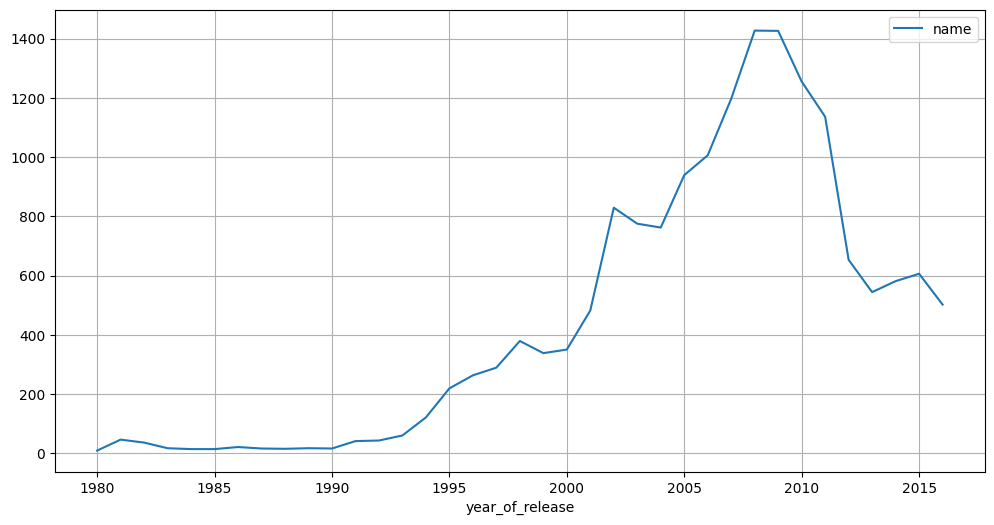

In [77]:
#строим гистограмму с распределением количества выпущенных игр по годам
data.pivot_table(index='year_of_release', values='name', aggfunc = 'count').plot(grid = True, kind ='line', figsize=(12, 6))

До 1995 года выпускалось стабильно меньше 200 игр в год, далее идет плавный рост,  пик по количеству выпущенных игр пришелся на 2008-2009 год,  далее идет спад и,  начиная с 2012 года, в среднем в год выпускатся примерно 600 игр. Данный период (последние 5 лет) можно считать наиболее важным в рамках нашего исследования

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами, далее построим распределение по годам. Для этого сохраним сводную таблицу с нужными данными в новый датафрейм data_platform,  отсортируем его по убыванию продаж методом  sort_values() с параметром ascending=False:

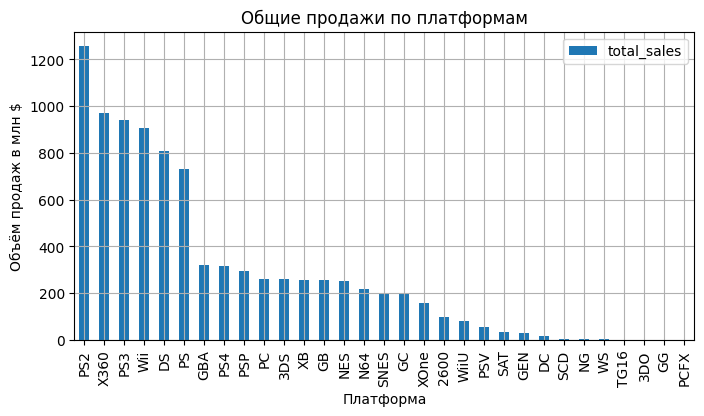

In [78]:
#сохраним данные с количеством продаж по платформам в отдельный датафрейм и отсортируем продажи по убыванию
data_platform = data.pivot_table(index='platform', values='total_sales', aggfunc = 'sum').sort_values(by= 'total_sales', ascending=False)
#построим график распределения продаж по платформам
data_platform.plot(grid = True, kind ='bar', figsize=(8, 4)).set(xlabel='Платформа', ylabel='Объём продаж в млн $')
plt.title('Общие продажи по платформам')
plt.show()

In [79]:
#Как мы видим больше всего продаж приходилось на 6 платформ
data_platform.head(6)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86


Посмотрим, как менялись продажи по платформам с течением времени. Выберем платформы с наибольшими суммарными продажами и построим распределение по годам

In [80]:
# Формируем 6 отдельных датафреймов для каждой платформы с помощью метода query()
PS2 = data.query('platform =="PS2"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
X360 = data.query('platform =="X360"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
PS3 = data.query('platform =="PS3"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
Wii = data.query('platform =="Wii"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
DS = data.query('platform =="DS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
PS = data.query('platform =="PS"').pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')


In [81]:
# Создадим сводную таблицу, где для каждой платформы указан ежегодный объём продаж, "склеим" методом .merge() по году выпуска игр
top6_data = (
    PS2.merge(X360, how='outer', on='year_of_release')
    .merge(PS3, how='outer', on='year_of_release')
    .merge(Wii, how='outer', on='year_of_release')
    .merge(DS, how='outer', on='year_of_release')
    .merge(PS, how='outer', on='year_of_release')
)

<ipython-input-81-0b95283b9098>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_sales_x'} in the result is deprecated and will raise a MergeError in a future version.
  PS2.merge(X360, how='outer', on='year_of_release')
<ipython-input-81-0b95283b9098>:3: FutureWarning: Passing 'suffixes' which cause duplicate columns {'total_sales_x'} in the result is deprecated and will raise a MergeError in a future version.
  PS2.merge(X360, how='outer', on='year_of_release')


<ipython-input-82-8c208bf71d5f>:2: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  top6_data.set_axis(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], axis = 'columns', inplace = True)


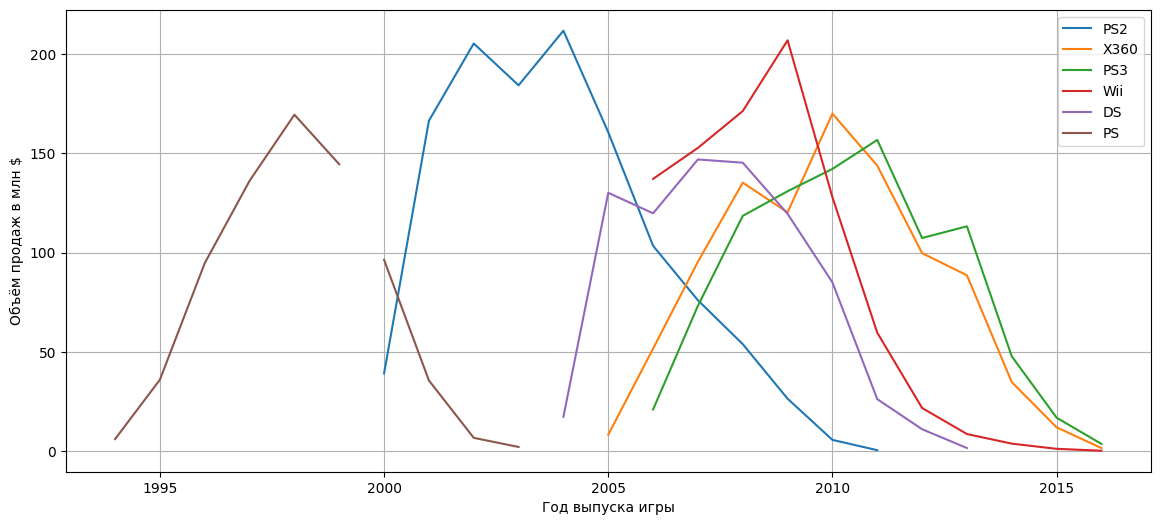

In [82]:
#переименуем столбцы в названия платформ методом set_axis() для наглядности 
top6_data.set_axis(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS'], axis = 'columns', inplace = True)
#Возьмем для анализа период после 1994 года,  когда стало выпускаться стабильно больше 200 игр в год
top6_data = top6_data.query('year_of_release >= 1994', engine='python')
#построим графики, отражающие динамику продаж игр по платформам
top6_data.plot(figsize=(14, 6), grid=True).set(xlabel='Год выпуска игры', ylabel='Объём продаж в млн $')
plt.show()

Существование платформ:
- PS - с 2004 по 2003 г - 9 лет
- PS2 - с 2000 по 2011г - 11 лет
- DS - с 2004 по 2013 г - 9 лет
- X360 - с 2005 по 2016 г - 11 лет
- Wii - с 2006 по 2016 г - 10 лет
- PS3 - с 2006 по 2016 г - 10 лет

**На основе данных графиков можно сделать следующие выводы:**
- Среднее время жизни платформы - 10 лет 
- Можно заметить преемственность поколений консолей PS,PS2,PS3 - выход новой модели и соответствующий рост продаж игр для нее соответствует падению  продаж игр для предыдущей модели
- в среднем пик продаж игр для каждой модели консоли наступает через  5 лет после ее появления, далее идет спад

In [83]:
#Создадим новый датафрейм,  в котором оставим данные только интересующего нас периода - с 2012 года включительно
data_new = data.query('year_of_release >= 2012', engine='python')

Проанализируем лидеров продаж в текущем периоде, для этого построим гистограмму с объемами продаж по каждой консоли, отсортировав ее по убыванию:

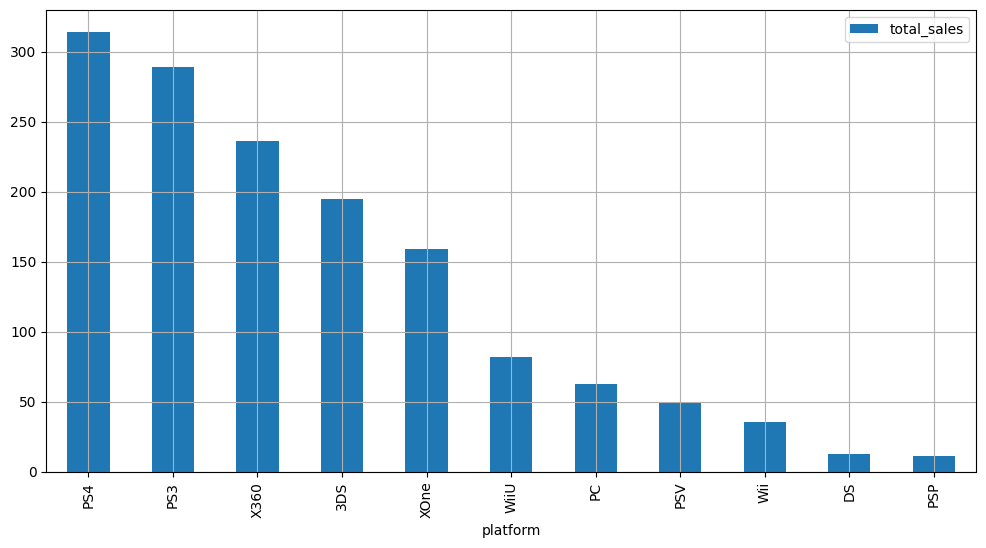

In [84]:
(
    data_new
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values('total_sales', ascending = False)
    .plot(y='total_sales', kind='bar', figsize=(12, 6), grid=True)
)
plt.show()

Лидерами продаж в актуальном периоде являются консоли PS4, PS3, X360, 3DS и WiiU
Что понять,  какие из  этих  платформ являются коммерчески перспективными,  нужно проанализировать динамику их  продаж за последние 3 года. Однако данные за 2016 год являюся неполными, поэтому будем считать перспективными консоли,  продажи которых в 2015 году были больше, чем в 2014 году
Создадим сводную таблицу с продажами по годам для кждой консоли:

In [85]:
data_new.pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc = 'sum')

total_sales
platform year_of_release             
3DS      2012                   51.36
         2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2012                   11.01
         2013                    1.54
PC       2012                   23.22
         2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2012                  107.36
         2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2012                    7.69
         2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2012                   16.19
         2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2012                   21.71
         2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2012                   17.56
         2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2012                   99.74
         2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

Согласно данным сводной таблицы, коммерчески перспективными являются только 2 консоли -  PS4 и Xone, у остальных консолей продажи в 2015 году были меньше, чем в 2014 году. Видимо на момент конца 2015 года  консоли PS4 и Xone были самыми современными,  поэтому показывали рост продаж. Остальные  консоли показывают спад  продаж от года к году

Для анализа глобальных продаж игр в разбивке по платформам построим диаграмму рессеивания "ящик с усами" для каждой платформы с помощью метода sns.boxplot() библиотеки seaborn. Чтобы выбрать формат оси y для начала посмотрим на числовое описание столбца с общими продажами методом describe()

count    2886.000000
mean        0.501223
std         1.249157
min         0.010000
25%         0.040000
50%         0.120000
75%         0.430000
max        21.050000
Name: total_sales, dtype: float64

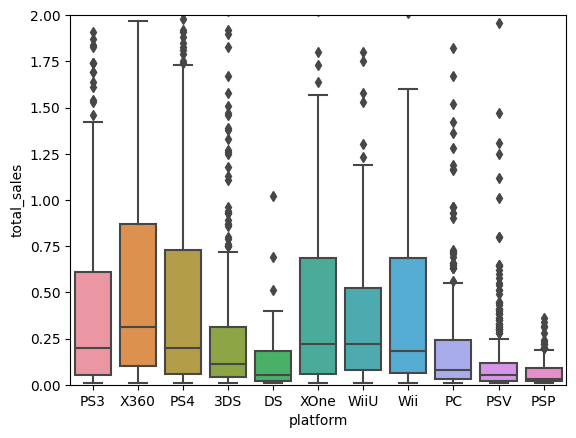

In [86]:
#смотрим на числовое описание столбца с общими продажами
display(data_new['total_sales'].describe())
#сторим диаграммы рассеивания для каждой платформы в одних  координатах
#т.к. 75% всех вариантов находится в диапазоне от 0 до 0,43 млн, то абсолютное большинство продаж 
ax = sns.boxplot(x="platform", y="total_sales", data=data_new)
ax.set_ylim(0, 2)
plt.show()

Выводы по числовому описанию столбца с продажами и диаграммам рассеивания:
- велична стандартного отклонения 1,25 говорит о том,  что в данных о продажах существует большое количество "выбросов", в нашем случае выбросами можно считать отдельные коммерчески успешные игры
- топ 6 платформ c cамым **высоким** показателем суммарного объёма продаж для каждой игры: X360, PS4, XOne, Wii, PS3, WiiU
- топ 5 платформ c cамым **низким** показателем суммарного объёма продаж для каждой игры: 3DS, PC, DS,PSV, PSP
- две наиболее потенциально прибыльные платформы PS4 и XOne имеют похожее распределение с медианой на уровне 0,24 млн и квартилями на уровнях 0,1 млн (1 квартиль) и 0,75 млн (3-й квартиль)
- платформа X360 имеет самые высокие показатели суммарного объёма продаж для каждой игры диапазон от 0.15 до 0.85 млн и медиану на уровне 0,33 млн
- платформа PSP имеет самые низкие показатели суммарного объёма продаж для каждой игры и наименьшее количество выбросов, то есть аномально коммерчески успешных игр

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Возьмем платформу X360, построим 2 диаграммы рассеяния и посчитаем корреляцию между отзывами и продажами

,user_score,critic_score,total_sales
user_score,1.000000,0.557352,0.006164
critic_score,0.557352,1.000000,0.360573
total_sales,0.006164,0.360573,1.000000


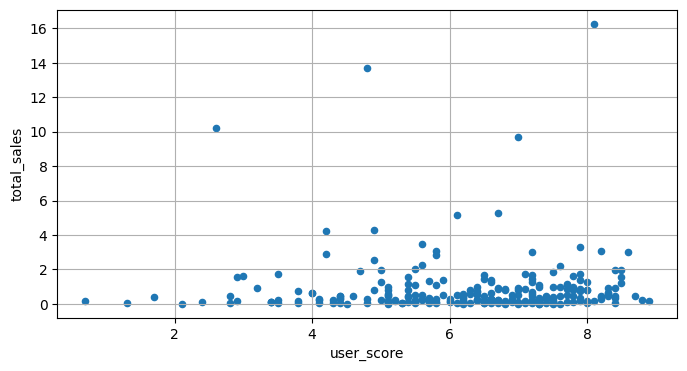

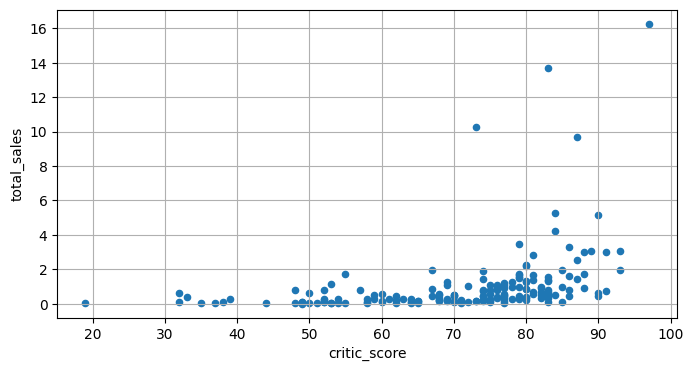

In [87]:
#диаграмма зависимости распределения продаж от оценок пользователей для платформы X360
data_new.query('platform == "X360"').plot(x='user_score', y='total_sales', kind='scatter',grid=True, figsize=(8, 4))
#диаграмма зависимости распределения продаж от оценок критиков для платформы X360
data_new.query('platform == "X360"').plot(x='critic_score', y='total_sales', kind='scatter',grid=True,figsize=(8, 4))
#построим матрицу корреляции оценок и общих  продаж для платформы X360
data_new.query('platform == "X360"')[['user_score','critic_score', 'total_sales']].corr()

Согласно данным матриц:
- корреляция между оценками пользователей и продажами игр практически отсутствует (0.006164),  причем можно заметить 2 выброса - коммерчески успешных игры с оценками 2,5 и 4,8. Такие аномалии могут говорить о хорошей рекламной компании отдельных игр,  которая приводила к большим продажам, однако разочаровала пользователей. Также такие аномалии могут возникать в случаях договорного поведения покупателей,  которые "обрушают" рейтинги игр по тем или иным причинам - баги в играх, плохая репутация разработчиков и т.п.
Также большое количество менее явных  выбросов находится в пространстве оценок от 4 до 9 баллов,  что может говорить о том, что коммерчески успешная игра может получать совершенно различные оценки. Больше всего проданных  игр имеют оценку от 5 до 8 баллов
- корреляция между оценками критиков и продажами игр более существенная (0.36) и имеет положительный характер, то есть чем выше оценка от критиков, тем более коммерчески успешна игра (вряд ли наоборот). Также о данной зависимости может говорить тот факт,  что большинство выбросов имеют оценку от 73 до 96 баллов
- покупатели больше доверяют мнению  критиков, нежели мнению обычных пользователей

Соотнесем полученные выводы с другими платформами, для анализа возьмем остальные платформы из топ-5 по общим продажам

In [88]:
display(data_new.query('platform == "PS4"')[['user_score','critic_score', 'total_sales']].corr())
display(data_new.query('platform == "PS3"')[['user_score','critic_score', 'total_sales']].corr())
display(data_new.query('platform == "XOne"')[['user_score','critic_score', 'total_sales']].corr())
data_new.query('platform == "3DS"')[['user_score','critic_score', 'total_sales']].corr()


,user_score,critic_score,total_sales
user_score,1.000000,0.557654,-0.031957
critic_score,0.557654,1.000000,0.406568
total_sales,-0.031957,0.406568,1.000000


,user_score,critic_score,total_sales
user_score,1.000000,0.539456,-0.005144
critic_score,0.539456,1.000000,0.331497
total_sales,-0.005144,0.331497,1.000000


,user_score,critic_score,total_sales
user_score,1.000000,0.472462,-0.068925
critic_score,0.472462,1.000000,0.416998
total_sales,-0.068925,0.416998,1.000000


,user_score,critic_score,total_sales
user_score,1.000000,0.722762,0.197583
critic_score,0.722762,1.000000,0.320803
total_sales,0.197583,0.320803,1.000000


По платформам PS4, PS3 и XOne мы видим схожую динамику  - корреляция оценок пользователей с продажами крайне мала (-0,032, -0,005 и -0,069 соответственно), корреляция оценок критиков с продажами на уровне 0,3 - 0,4 (точнее 0,41 ,  0,33 и  0,42 соответственно), что подтверждает ранее сделанные выводы.
Отличается только корреляция оценок пользователей с продажами у платформы 3DS, она выше и сотавляет 0,2. Это может говорить о том, что платформа лучше собирает обратную связь от покупателей, мотивируя их оставлять положительные оценки.
Однако, мы знаем,  что данные с оценками от пользователей имеют 54,6% пропусков, поэтому данная корреляция может также иметь случайный характер,  обусловленный недостатком данных.

Далее посмотрим на общее распределение игр по жанрам,  а также определим самые прибыльные жанры,  если таковые есть.Для этого построим 2 диаграммы, где отобразим количество выпущенных игр по жанрам,  а также общие продажи игр по жанрам. Данные обеих диаграмм отсортируем по убыванию значений для наглядности:

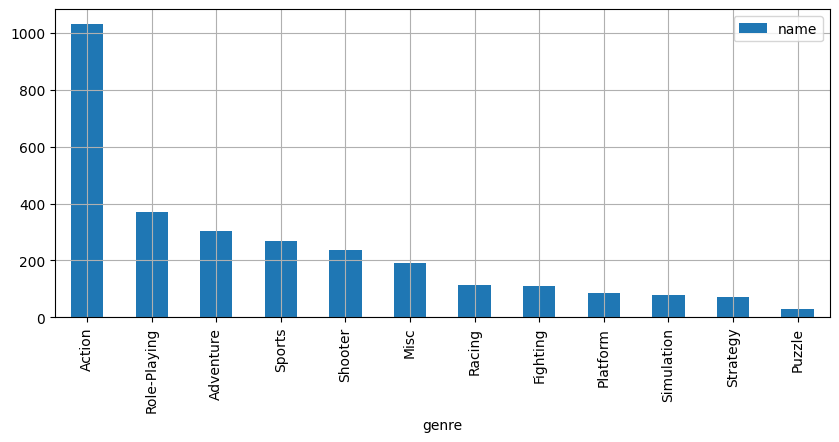

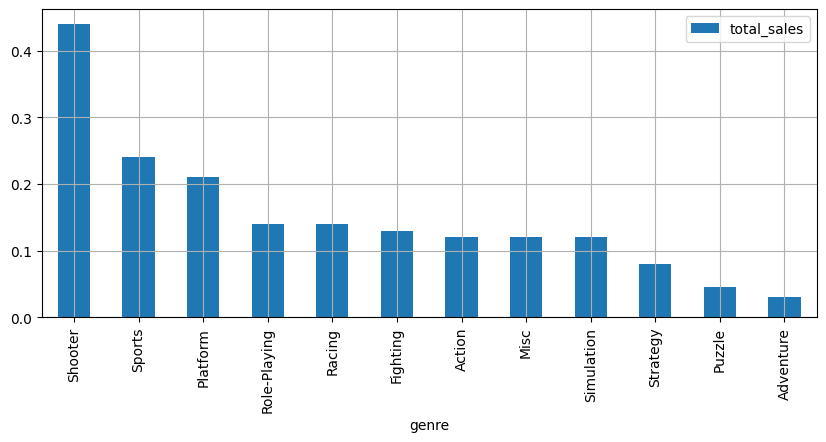

In [97]:
(#строим диаграмму распределения выпущенных игр по жанрам
    data_new
    .pivot_table(index='genre', values='name', aggfunc='count')
    .sort_values('name', ascending = False)
    .plot(y='name', kind='bar', figsize=(10, 4), grid=True)
)
plt.show()
(#строим диаграмму распределения продаж игр по жанрам
    data_new
    .pivot_table(index='genre', values='total_sales', aggfunc='median')
    .sort_values('total_sales', ascending = False)
    .plot(y='total_sales', kind='bar', figsize=(10, 4), grid=True)
)
plt.show()

<div class="alert alert-info">
Топ-5 жанров по количеству выпущенных игр за выбранный период :Action (более 1000 шт), Role-Playing (примерно 380 шт), Adventure (примерно 300 шт), Sports (250 шт), Shooter (220 шт)
    
Топ-5 жанров по медианным продажам игр за выбранный период: Shooter (0,45 млн долл), Sports (0,24 млн долл), Platform (0,21 млн долл), Role-Playing (примерно 0,14 млн долл), Racing (примерно 0,14 млн долл)

Можно сделать вывод, что большое количество выпущенных игр в том или ином жанре не гарантирует высоких продаж этого жанра. Самым прибыльным является жанр Shooter

По количеству выпущенных игр лидирует жанр Action - в этом жанре выпускалось больше всего игр в выбранном периоде (более 1000 шт) , но они принесли всего около 120 млн долл выручки. По объему продаж  лидируют игры в жанре Shooter.
Далее ситуация не так однозначна:
- игры в жанре Role-Playing занимают второе место по количеству выпущенных игр (примерно 380 шт), но по продажам занимают 4 место (190 млн)
- игры в жанре Adventure занимают третье место по количеству выпущенных игр (примерно 300 шт), но по продажам занимают 12 место (менее 25 млн)
- на 4-м месте по выпуску находятся игры в жанре Sports - 250 выпущенных игр принесли около 240 млн выручки,  что является вторым результатом
- на 5 месте по количеству выпущенных игр находятся игры в стиле Shooter - 220 игр,  а вот по продажам этот жанр находится на 1 месте с показателем в 450 млн. Можно сказать, это этот жанр является одним из самых прибыльных для разработчиков

### Составим портрет пользователя каждого региона

Для этого определим для пользователя каждого региона (NA, EU, JP):

•	Самые популярные платформы (топ-5)

•	Самые популярные жанры (топ-5)

•	Влияет ли рейтинг ESRB на продажи в отдельном регионе. Расшифровка рейтинга:
- «M» («Mature») — «Для взрослых»: Материалы игры не подходят для лиц младше 17 лет
- «T» («Teen») — «Подросткам»: Игра подходит для лиц от 13 лет
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше»
- «E» («Everyone») — «Для всех»

Для определения построим последовательно 3 диаграммы для каждого региона: Самые популярные платформы (болшее количество продаж)б самые популярные жанры (большее количество продаж) и продажи игр в зависимости от рейтинга. Для обозначения долей рынка удобнее всего использовать круговую диаграмму, для этого используем параметр kind='pie'.
Начнем с региона NA - Северная Америка

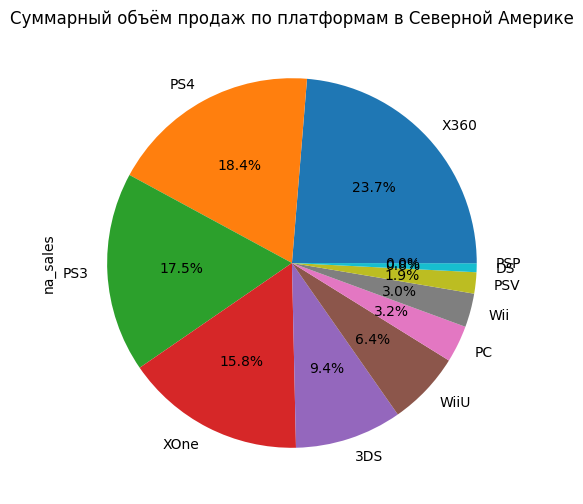

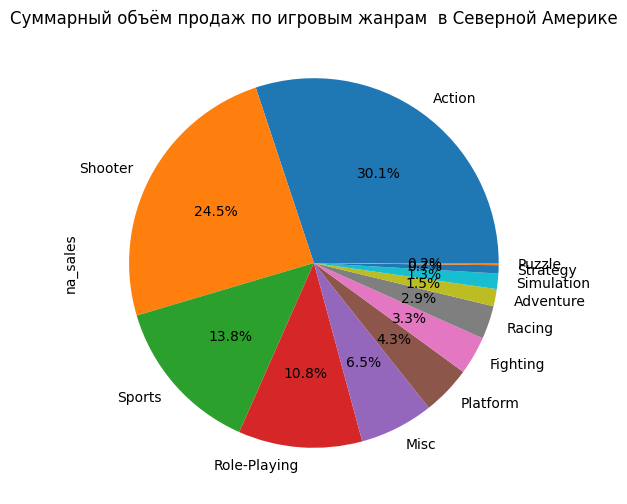

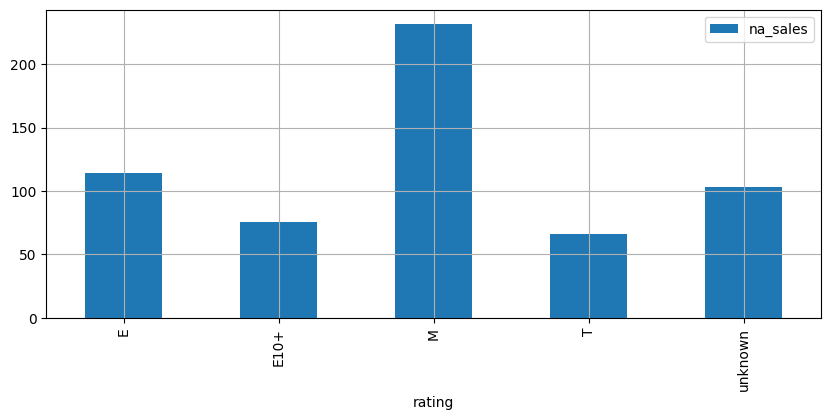

In [91]:
(#самые популярные платформы
    data_new
    .pivot_table(index='platform', values='na_sales', aggfunc='sum')
    .sort_values('na_sales', ascending = False)
    .plot(y='na_sales', kind='pie', figsize=(6, 6), autopct='%1.1f%%',legend = False)
)
plt.title('Суммарный объём продаж по платформам в Северной Америке') # Название диаграммы
plt.show()
(#самые популярные жанры
    data_new
    .pivot_table(index='genre', values='na_sales', aggfunc='sum')
    .sort_values('na_sales', ascending = False)
    .plot(y='na_sales', kind='pie', figsize=(6, 6), autopct='%1.1f%%', legend = False)
)
plt.title('Суммарный объём продаж по игровым жанрам  в Северной Америке') # Название диаграммы
plt.show()
(#продажи по категориям рейтинга организации ESRB
    data_new
    .pivot_table(index='rating', values='na_sales', aggfunc='sum')
    .plot(y='na_sales', kind='bar', figsize=(10, 4), grid=True)
)
plt.show()

Вывод по региону Северная Америка:
- Топ-5 платформ: X360, PS4, PS3, XOne, 3DS. Различия по объему продаж составляют 1-6%. Монополии одной платформы на рынке нет. Суммарные продажи лидеров рынка - платформ Xbox (39,5%) и PS (35,9%) составляют 75,4% продаж всех игр среди топ-5 платформ
- Топ-5 жанров: Action, Shooter, Sports, Role-Playing, Misc. Более 50% продаж составляют игры в двух жанрах (Action и Shooter), направленные на более возрослую аудиторию
- Данную теорию  и подтверждают данные о продажах по рейтингу - больше всего игр продается с рейтингом M — "Для взрослых"

**Типичный покупатель в Северной Америке старше 17 лет, играет в игры в стиле Action на консоли X360**

Диаграммы для региона EU - Европа:

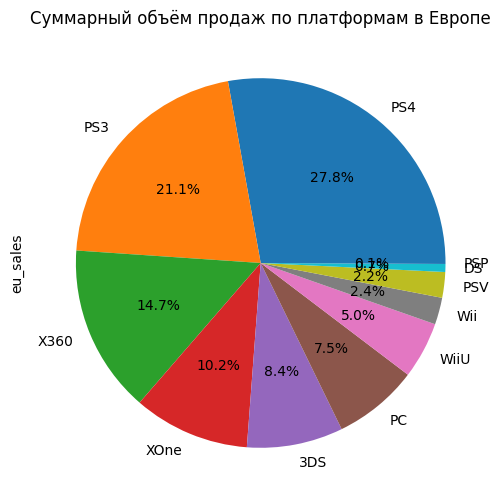

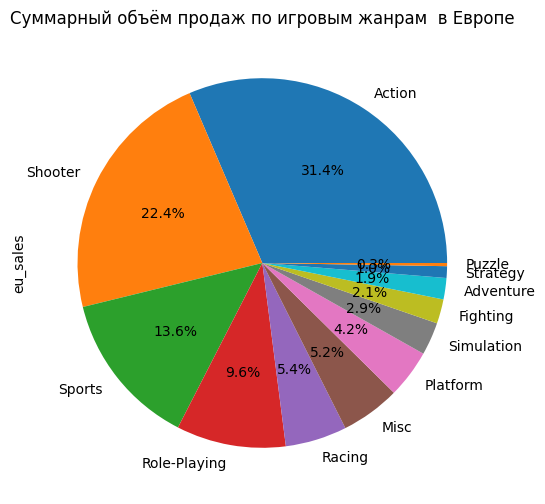

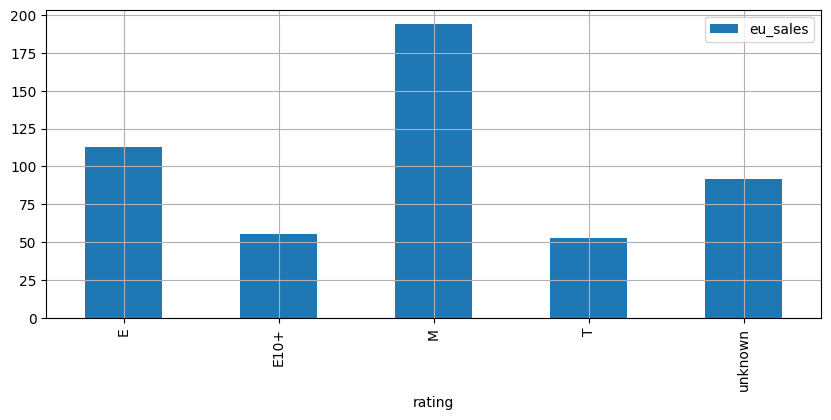

In [92]:
(#самые популярные платформы
    data_new
    .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
    .sort_values('eu_sales', ascending = False)
    .plot(y='eu_sales', kind='pie', figsize=(6, 6), autopct='%1.1f%%',legend = False)
)
plt.title('Суммарный объём продаж по платформам в Европе') # Название диаграммы
plt.show()
(#самые популярные жанры
    data_new
    .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
    .sort_values('eu_sales', ascending = False)
    .plot(y='eu_sales', kind='pie', figsize=(6, 6), autopct='%1.1f%%', legend = False)
)
plt.title('Суммарный объём продаж по игровым жанрам  в Европе') # Название диаграммы
plt.show()
(#продажи по категориям рейтинга организации ESRB
    data_new
    .pivot_table(index='rating', values='eu_sales', aggfunc='sum')
    .plot(y='eu_sales', kind='bar', figsize=(10, 4), grid=True)
)
plt.show()

Вывод по региону Европа:
- Топ-5 платформ:  PS4, PS3, X360, XOne, 3DS. Суммарные продажи консолей PS составляют 48,9% рынка, ближайшего конкурента из Топ-5 - Xbox - 24,9%, что говорит о большей популярности консоли от компании Sony на рынке Европы почти в 2 раза.
- Топ-5 жанров: Action, Shooter, Sports, Role-Playing, Racing. Более 50% продаж составляют игры в двух жанрах (Action и Shooter), направленные на более возрослую аудиторию. Распределение аналогично рынку Северной Америки за исключением 5 места - его занимают игры в стиле Racing
- Распределение продаж игр по рейтингу аналогично рынку Северной Америки - больше всего игр продается с рейтингом M — "Для взрослых".

**Типичный покупатель в Европе старше 17 лет, играет в игры в стиле Action на консоли PS4**

<div class="alert alert-info">
Также важно отметить, что в регионе Европа дейтсвует своя система руйтингов игр -  Pan European Game Information (PEGI) — европейская рейтинговая система компьютерных игр и другого развлекательного программного обеспечения,  поэтому многие игры могут не иметь оценки от ESRB

Диаграммы для региона JP - Япония:

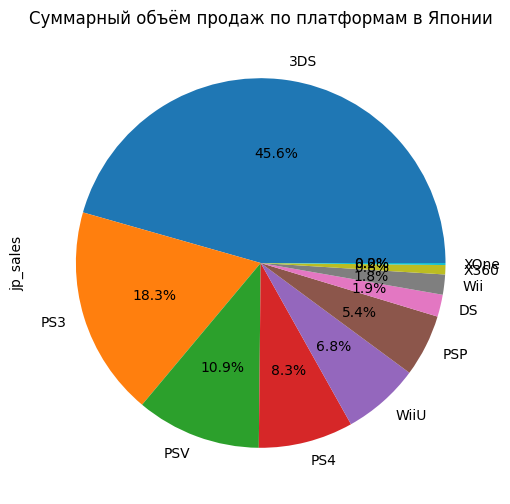

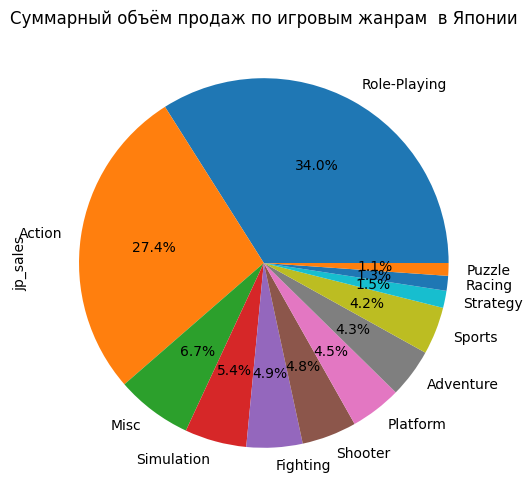

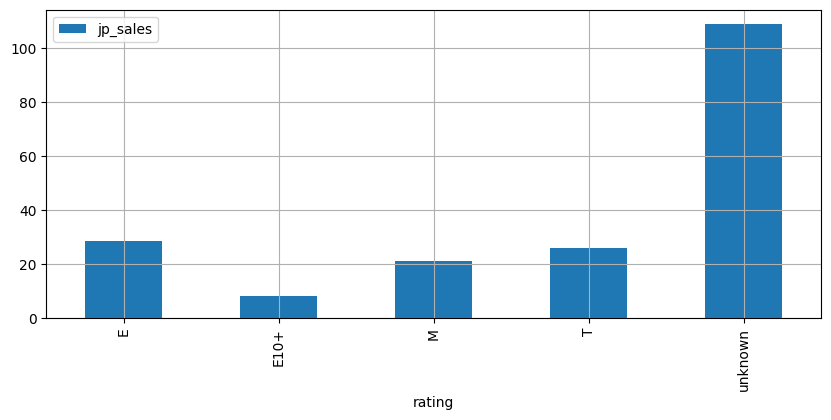

In [93]:
(#самые популярные платформы
    data_new
    .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
    .sort_values('jp_sales', ascending = False)
    .plot(y='jp_sales', kind='pie', figsize=(6, 6), autopct='%1.1f%%',legend = False)
)
plt.title('Суммарный объём продаж по платформам в Японии') # Название диаграммы
plt.show()
(#самые популярные жанры
    data_new
    .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
    .sort_values('jp_sales', ascending = False)
    .plot(y='jp_sales', kind='pie', figsize=(6, 6), autopct='%1.1f%%', legend = False)
)
plt.title('Суммарный объём продаж по игровым жанрам  в Японии') # Название диаграммы
plt.show()
(#продажи по категориям рейтинга организации ESRB
    data_new
    .pivot_table(index='rating', values='jp_sales', aggfunc='sum')
    .plot(y='jp_sales', kind='bar', figsize=(10, 4), grid=True)
)
plt.show()

Вывод по региону Япония:

- Топ-5 платформ: 3DS, PS3, PSV, PS4, Wii. Продажи консолей PS составляют 45,6% рынка, суммарные продажи ближайшего конкурента - PS - 37,5%. Немало важно,  что все топ-5 консолей производятся японскими компаниями, поэтому можно говорить о наличии только внутренней конкуренции среди платформ в Японии.
- Топ-5 жанров: Role-Playing, Action, Misc, Simulation, Fighting. 34% продаж составляют игры в жанре Role-Playing, игры в жанре Action занимают второе место. Можно утверждать, что распределение популярных игр отличается от рынков Европы и Америки. 
- Распределение продаж игр по рейтингу также отличается - больше всего игр продается с неопределенным рейтингом, далее идут рейтинги E — "Для всех" и Т - "Для подростков"


<div class="alert alert-info">
Распределение продаж игр по рейтингу также отличается - как ни странно, самые большие продажи имеют игры без оценки от ESRB - суммарные продажи игр без оценки примерно равны продажам всех остальных игр. Однако это не означает, что покупатели целенаправленно покупают игры без оценки. 
В Японии не котируются оценки от ESRB, а чтобы выпустить игру в продажу, необходимо получить рейтинг от CERO – некоммерческой организации, основанная в июле 2002-го.
Более подробно можно почитать об этом здесь

https://kanobu.ru/articles/stavlyu-na-cero-368311/
    
**Типичного покупателя в Японии сложно идентифицировать по возрасту, но он играет в игры в стиле Role-Playing на консоли 3DS**

<div class="alert alert-info">

Общий вывод  касательно  влияния рейтинга ESRB на продажи сделать сложно, по данным видно, что игры определенного рейтинга в разных регионах популярнее других, однако установить прямую корреляцию и подтвердить, что именно рейтинг игры от организации TSRB влияет на ее продажи, не представляется возможным,  в том числе и потому, что в разных регионах дейтсвуют различные системы присвоения рейтинга

### Проверим гипотезы

Сформулируем первую нулевую гипотезу  - "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"

Альтернативной гипотезой будет служить формулировка "Средние пользовательские рейтинги платформ Xbox One и PC разные"


Для проверки данной гипотезы, необходимо воспользоваться методом проверки гипотезы о равенстве средних двух независимых генеральных совокупностей методом scipy.stats.ttest_ind()
Для этого нужно создать две генеральных  совокупности - в нашем случае два списка значений с оценками от пользователей для платформ XOne и PC, удалив из них  пропущенные значения,  иначе они повлияют на результат.
Т.к. у нас нет уверенности, что получившиеся выборки будут равны по объему и равны их  дисперсии,  установим параметр  equal_var= False

In [94]:
#список значений с оценками от пользователей для платформы XOne
sample_xone = data_new.query('platform =="XOne"')['user_score'].dropna()
#список значений с оценками от пользователей для платформы PC
sample_pc = data_new.query('platform =="PC"')['user_score'].dropna()
# установим стандартный критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу
alpha = .05 
# Проверка нулевой гипотезы
results = st.ttest_ind(sample_xone, sample_pc, equal_var= False)
print('p-значение:', results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


**Не удалось отвергнуть нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC действительно одинаковые**

Также необходимо сравнить средние пользовательские рейтинги жанров Action(англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования»)

По аналогии с предыдущей гипотезой можно сформировать нулевую гипотезу как 
"Средние пользовательские рейтинги жанров Actio и Sports одинаковы"

тогда альтернативная гипотеза будет звучать как "Средние пользовательские рейтинги жанров Action и Sports разные"

и проверить такую гипотезу можно тем же способом:

In [95]:
#список значений с оценками от пользователей игр жанра Action
sample_action = data_new.query('genre =="Action"')['user_score'].dropna()
#список значений с оценками от пользователей игр жанра Sports
sample_sports = data_new.query('genre =="Sports"')['user_score'].dropna()
# установим стандартный критический уровень статистической значимости, если p-value окажется меньше него - отвергнем гипотезу
alpha = .05 
# Проверка нулевой гипотезы
results = st.ttest_ind(sample_action, sample_sports, equal_var= False)
print('p-значение: {:.25f}'.format(results.pvalue))#полученное значение крайне мало, округлим его
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.0000000000000000000424308
Отвергаем нулевую гипотезу


**Отвергаем нулевую гипотезу, средние пользовательские рейтинги жанров Action и Sports разные**

### Общий вывод

Целью нашего исследования являлось выявление закономерностей, определяющей успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.
Удалось выявить следующие закономерности:
- До 1995 года выпускалось стабильно меньше 200 игр в год, далее следовал плавный рост, пик по количеству выпущенных игр пришелся на 2008-2009 год, далее шел спад и, начиная с 2012 года, в среднем в год выпускалось примерно 600 игр. Данный **период (последние 5 лет) можно считать наиболее важным в рамках нашего исследования**
- Среднее время жизни игоровой платформы на рынке - 10 лет. Можно заметить преемственность поколений консолей - выход новой модели и соответствующий рост продаж игр для нее соответствует падению продаж игр для предыдущей модели. В среднем пик продаж игр для каждой модели консоли наступает через 5 лет после ее появления, далее идет спад
- Лидерами по общим продажам во всех регионах в актуальном периоде являются консоли PS4, PS3, X360, 3DS и WiiU. Однако **коммерчески перспективными на глобальном рынке являются только 2 консоли - PS4 и Xone**, у остальных консолей продажи в 2015 году были меньше, чем в 2014 году (данные за 2016 год неполные). После дополнения данных за 2016 год необходимо провести повторное исследование
- топ 6 платформ c cамым высоким показателем **суммарного объёма продаж во всех регионах** для каждой игры: X360, PS4, XOne, Wii, PS3, WiiU. две наиболее потенциально прибыльные платформы PS4 и XOne имеют похожее распределение с медианой на уровне 0,24 млн и квартилями на уровнях 0,1 млн (1 квартиль) и 0,75 млн (3-й квартиль), платформа X360 имеет самые высокие показатели суммарного объёма продаж для каждой игры диапазон от 0.15 до 0.85 млн и медиану на уровне 0,33 млн
- **корреляция между оценками пользователей и продажами игр практически отсутствует (показатель около 0)**, то есть коммерчески успешная игра может получать совершенно различные оценки. Больше всего проданных игр имеют оценку от 5 до 8 баллов по 10-балльной шкале
- **корреляция между оценками критиков и продажами игр более существенная (0.36 - 0.4) и имеет положительный характер, то есть чем выше оценка от критиков, тем более коммерчески успешна игра** (вряд ли наоборот). Также о данной зависимости может говорить тот факт, что большинство выбросов (коммерчески успешных игр) имеют оценку от 73 до 96 баллов
- можно сделать вывод, что покупатели больше доверяют мнению критиков, нежели мнению обычных пользователей
- Общий вывод  касательно  влияния рейтинга ESRB на продажи сделать сложно, по данным видно, что игры определенного рейтинга в разных регионах популярнее других, однако установить прямую корреляцию и подтвердить, что именно рейтинг игры от организации TSRB влияет на ее продажи, не представляется возможным,  в том числе и потому, что в разных регионах дейтсвуют различные системы присвоения рейтинга
- Топ-5 жанров по количеству выпущенных игр за выбранный период :Action (более 1000 шт), Role-Playing (примерно 380 шт), Adventure (примерно 300 шт), Sports (250 шт), Shooter (220 шт)
- Топ-5 жанров по медианным продажам игр за выбранный период: Shooter (0,45 млн долл), Sports (0,24 млн долл), Platform (0,21 млн долл), Role-Playing (примерно 0,14 млн долл), Racing (примерно 0,14 млн долл)

Можно сделать вывод, что большое количество выпущенных игр в том или ином жанре не гарантирует высоких продаж этого жанра. Самым прибыльным является жанр Shooter

**Отдельные выводы по трем регионам продаж:**

Северная Америка:

Топ-5 платформ: X360, PS4, PS3, XOne, 3DS. Различия по объему продаж составляют 1-6%. Монополии одной платформы на рынке нет. Суммарные продажи лидеров рынка - платформ Xbox (39,5%) и PS (35,9%) составляют 75,4% продаж всех игр среди топ-5 платформ
Топ-5 жанров: Action, Shooter, Sports, Role-Playing, Misc. Более 50% продаж составляют игры в двух жанрах (Action и Shooter), направленные на более возрослую аудиторию
Данную теорию и подтверждают данные о продажах по рейтингу - больше всего игр продается с рейтингом M — "Для взрослых"
**Типичный покупатель в Северной Америке старше 17 лет, играет в игры в стиле Action на консоли X360**

Европа:

Топ-5 платформ: PS4, PS3, X360, XOne, 3DS. Суммарные продажи консолей PS составляют 48,9% рынка, ближайшего конкурента из Топ-5 - Xbox - 24,9%, что говорит о большей популярности консоли от компании Sony на рынке Европы почти в 2 раза.
Топ-5 жанров: Action, Shooter, Sports, Role-Playing, Racing. Более 50% продаж составляют игры в двух жанрах (Action и Shooter), направленные на более возрослую аудиторию. Распределение аналогично рынку Северной Америки за исключением 5 места - его занимают игры в стиле Racing
Распределение продаж игр по рейтингу аналогично рынку Северной Америки - больше всего игр продается с рейтингом M — "Для взрослых".
**Типичный покупатель в Европе старше 17 лет, играет в игры в стиле Action на консоли PS4**

Япония:

Топ-5 платформ: 3DS, PS3, PSV, PS4, Wii. Продажи консолей PS составляют 45,6% рынка, суммарные продажи ближайшего конкурента - PS - 37,5%. Немало важно, что все топ-5 консолей производятся японскими компаниями, поэтому можно говорить о наличии только внутренней конкуренции среди платформ в Японии.
Топ-5 жанров: Role-Playing, Action, Misc, Simulation, Fighting. 34% продаж составляют игры в жанре Role-Playing, игры в жанре Action занимают второе место. Можно утверждать, что распределение популярных игр отличается от рынков Европы и Америки.
Распределение продаж игр по рейтингу также отличается - как ни странно, самые большие продажи имеют игры без оценки от ESRB - суммарные продажи игр без оценки примерно равны продажам всех остальных игр. Однако это не означает, что покупатели целенаправленно покупают игры без оценки. 

**Типичного покупателя в Японии сложно идентифицировать по возрасту, но он играет в игры в стиле Role-Playing на консоли 3DS**
 

Возможные рекомендации на 2017 год на основе выводов исследования:
- Делать ставку на современные платформы. Предлагать вышедшие и новые игры на PS4, XOne.
- Предлагать популярные жанры -  Shooter, Platform, Sports, Racing и Role-Paying .
- Предлагать игры для более взрослой аудитории на рынках Северной Америки и Европы,  для рынка Японии - изучить местные нормы присвоения возрастного рейтинга
- Предлагать игры с высокими оценками от критиков

<div class="alert alert-info">
Спасибо большое за конструктивные замечания, всё поправил,  выводы изменил/дописал.